Transfer Learning with Chest X-ray Data and Inception v2

2018270679 윤아로

In [2]:
# Mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set Dir.
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearning/TransferLearning')
%pwd

'/content/drive/My Drive/Colab Notebooks/MachineLearning/TransferLearning'

In [49]:
# Import modules
from __future__ import print_function, division

import copy
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [50]:
# 현재 위치 확인
root_path = os.getcwd()
print(root_path)

# 각 데이터 셋에 따른 경로 지정
data_path = './chest_xray'
print(data_path)
train_path = os.path.join(data_path, 'train')
print(train_path)
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

# 클래스 정보 지정
class_names = os.listdir(train_path)
class_num = len(class_names)    # 클래스 개수

# 각 폴더( train / val / test )에 클래스 정보 담기 
for class_name in class_names:
    train_sub_path = train_path + '/' + class_name
    val_sub_path = val_path + '/' + class_name
    test_sub_path = test_path + '/' + class_name
    print('The number of ' + class_name + ' dataset(Train) : ', len(os.listdir(train_sub_path)))
    print('The number of ' + class_name + ' dataset(Validation) : ', len(os.listdir(val_sub_path)))
    print('The number of ' + class_name + ' dataset(Test) : ', len(os.listdir(test_sub_path)))


/content/drive/My Drive/Colab Notebooks/MachineLearning/TransferLearning
./chest_xray
./chest_xray/train
The number of PNEUMONIA dataset(Train) :  3875
The number of PNEUMONIA dataset(Validation) :  8
The number of PNEUMONIA dataset(Test) :  390
The number of NORMAL dataset(Train) :  1341
The number of NORMAL dataset(Validation) :  8
The number of NORMAL dataset(Test) :  234


In [51]:
# Data Augmentation
# Inception v3 Network를 사용할 것이기 때문에 사이즈를 299로 맞추어주었음
data_transform = {  # image transformation (dictionary)
    'train': transforms.Compose([
        transforms.Resize(299),     # 이미지 크기 resize
        transforms.CenterCrop(299), # 가운데를 기준으로 cropping
        transforms.ToTensor(),      # Tensor 형태로
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(RGB에 대한 평균값과 standard diviation)
    ]),
    'val': transforms.Compose([
        transforms.Resize(299), 
        transforms.CenterCrop(299), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [22]:
print(data_transform)

{'train': Compose(
    Resize(size=299, interpolation=bilinear)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=299, interpolation=bilinear)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [52]:
# Load Data

# ImageFolder를 이용하여 구조화된 디렉터리를 만들어서 data set에 넣고 사용
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transform[x])
                  for x in ['train', 'val']}
print(image_datasets)
print('The number of dataset(Train) after Augmentation : ', len(image_datasets['train']))
print('The number of dataset(Validation) after Augmentation : ', len(image_datasets['val']))

# data loader 생성하여 불러오기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)


{'train': Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
The number of dataset(Train) after Augmentation :  5216
The number of dataset(Validation) after Augmentation :  16
{'train': 5216, 'val': 16}


In [53]:
# Set device (cuda Env.)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


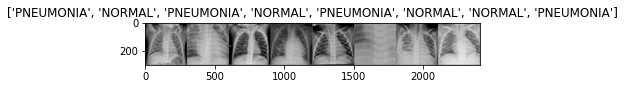

In [24]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [54]:
# Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []
    val_loss_history = []

    # 모델의 weight, bias 등 모든 정보를 복사
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # initialization

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train과 validation을 한번씩(overfitting 모니터링하기에 좋음)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  # train과 validation할때 모드를 바꾸어줌

            running_loss = 0.0
            running_corrects = 0

            # data load에서 mini-batch만큼 가져와서 GPU로 보냄
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Initialize optimizer
                optimizer.zero_grad()  

                # train mode일때 gradient를 enable, 즉 back-prop 하겠단 뜻
                # inception v3를 사용할 것이기 때문에 auxiliary output을 가진다
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                        val_loss_history.append(loss)

                    # 1축 방향으로 index 가져오기 (acc 정할때 사용)
                    _, preds = torch.max(outputs, 1)

                    # train mode 일때만 backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # best model 찾기
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                # print(val_acc_history)

        print()

    time_elapsed = time.time() - since  # 실행 시간
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history  # best model을 return

In [55]:
# Finetuning the convnet
# Useing Inception_v3 Model
model_ft = models.inception_v3(pretrained=True)
num_ftrs = model_ft.fc.in_features

# last fully connected layer를 원하는대로 바꾸어줌
# 현재 데이터에서는 2개의 클래스만 구별하면 됨
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# 마지막 바꾼 레이어를 다시 optimization
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# epoch 7번 마다 감마를 0.1로 줄여가겠다고 정의
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
print(num_ftrs)

2048


In [18]:
# Model training
# CALL train_model()
# epoch == 10
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1811 Acc: 0.9555
val Loss: 0.4408 Acc: 0.6250

Epoch 1/9
----------
train Loss: 0.0854 Acc: 0.9797
val Loss: 0.0361 Acc: 0.5625

Epoch 2/9
----------
train Loss: 0.0374 Acc: 0.9912
val Loss: 0.0165 Acc: 0.6250

Epoch 3/9
----------
train Loss: 0.0282 Acc: 0.9927
val Loss: 0.0040 Acc: 0.5000

Epoch 4/9
----------
train Loss: 0.0248 Acc: 0.9935
val Loss: 0.0217 Acc: 0.5000

Epoch 5/9
----------
train Loss: 0.0108 Acc: 0.9979
val Loss: 0.0146 Acc: 0.4375

Epoch 6/9
----------
train Loss: 0.0095 Acc: 0.9975
val Loss: 0.0004 Acc: 0.6250

Epoch 7/9
----------
train Loss: 0.0065 Acc: 0.9990
val Loss: 0.0020 Acc: 0.6250

Epoch 8/9
----------
train Loss: 0.0051 Acc: 0.9990
val Loss: 0.0155 Acc: 0.5000

Epoch 9/9
----------
train Loss: 0.0076 Acc: 0.9987
val Loss: 0.0003 Acc: 0.4375

Training complete in 46m 41s
Best val Acc: 0.625000


In [56]:
# epoch == 25
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3362 Acc: 0.9310
val Loss: 0.0095 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.0899 Acc: 0.9758
val Loss: 0.0824 Acc: 0.6250

Epoch 2/24
----------
train Loss: 0.0471 Acc: 0.9893
val Loss: 0.0042 Acc: 0.4375

Epoch 3/24
----------
train Loss: 0.0235 Acc: 0.9942
val Loss: 0.2310 Acc: 0.4375

Epoch 4/24
----------
train Loss: 0.0111 Acc: 0.9981
val Loss: 0.0011 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.0106 Acc: 0.9987
val Loss: 0.0014 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.0089 Acc: 0.9979
val Loss: 0.0022 Acc: 0.3750

Epoch 7/24
----------
train Loss: 0.0061 Acc: 0.9985
val Loss: 0.0011 Acc: 0.4375

Epoch 8/24
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.0029 Acc: 0.6250

Epoch 9/24
----------
train Loss: 0.0055 Acc: 0.9992
val Loss: 0.0005 Acc: 0.4375

Epoch 10/24
----------
train Loss: 0.0048 Acc: 0.9996
val Loss: 0.0004 Acc: 0.5000

Epoch 11/24
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.0003 Acc: 0.5000

Ep

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe844081050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe844081050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.0034 Acc: 0.9994


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe844081050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.0004 Acc: 0.6250

Epoch 14/24
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe844081050>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe844081050>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

train Loss: 0.0026 Acc: 0.9998
val Loss: 0.0002 Acc: 0.4375

Epoch 15/24
----------
train Loss: 0.0029 Acc: 0.9998
val Loss: 0.0004 Acc: 0.4375

Epoch 16/24
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.0003 Acc: 0.6250

Epoch 17/24
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0007 Acc: 0.5625

Epoch 18/24
----------
train Loss: 0.0035 Acc: 0.9998
val Loss: 0.0011 Acc: 0.4375

Epoch 19/24
----------
train Loss: 0.0032 Acc: 0.9998
val Loss: 0.0009 Acc: 0.5625

Epoch 20/24
----------
train Loss: 0.0038 Acc: 0.9990
val Loss: 0.0010 Acc: 0.6250

Epoch 21/24
----------
train Loss: 0.0045 Acc: 0.9996
val Loss: 0.0014 Acc: 0.5000

Epoch 22/24
----------
train Loss: 0.0033 Acc: 0.9998
val Loss: 0.0024 Acc: 0.6875

Epoch 23/24
----------
train Loss: 0.0022 Acc: 0.9998
val Loss: 0.0013 Acc: 0.8750

Epoch 24/24
----------
train Loss: 0.0031 Acc: 0.9998
val Loss: 0.0027 Acc: 0.3750

Training complete in 83m 25s
Best val Acc: 0.875000


In [40]:
""" Saving & Loading trained Model """

# Save model (epoch 25)
# torch.save(model_ft.state_dict(), "model.pth")

# Load model 
model_ft.load_state_dict(torch.load("model.pth")) 

<All keys matched successfully>

In [47]:
# Save model (epoch 10)
# torch.save(model_ft.state_dict(), 'model_e10.pth')

In [31]:
""" ConvNet as fixed feature extractor """
""" Optimizer == RMSprop """
model_conv = torchvision.models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.RMSprop(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.9761 Acc: 0.8639
val Loss: 3.9611 Acc: 0.3125

Epoch 1/24
----------
train Loss: 3.8963 Acc: 0.8765
val Loss: 3.6616 Acc: 0.4375

Epoch 2/24
----------
train Loss: 3.9055 Acc: 0.8831
val Loss: 4.2029 Acc: 0.5000

Epoch 3/24
----------
train Loss: 3.9429 Acc: 0.8844
val Loss: 4.0300 Acc: 0.5000

Epoch 4/24
----------
train Loss: 3.8789 Acc: 0.8892
val Loss: 3.1766 Acc: 0.5625

Epoch 5/24
----------
train Loss: 3.9412 Acc: 0.8859
val Loss: 4.3852 Acc: 0.5000

Epoch 6/24
----------
train Loss: 4.0171 Acc: 0.8854
val Loss: 3.1246 Acc: 0.6250

Epoch 7/24
----------
train Loss: 3.8116 Acc: 0.9051
val Loss: 3.5232 Acc: 0.4375

Epoch 8/24
----------
train Loss: 3.7952 Acc: 0.9049
val Loss: 3.2295 Acc: 0.5625

Epoch 9/24
----------
train Loss: 3.7810 Acc: 0.9003
val Loss: 3.9711 Acc: 0.4375

Epoch 10/24
----------
train Loss: 3.7074 Acc: 0.9062
val Loss: 3.9480 Acc: 0.3750

Epoch 11/24
----------
train Loss: 3.7490 Acc: 0.9032
val Loss: 5.5362 Acc: 0.5000

Ep

In [11]:
""" Optimizer == SGD """
model_conv = torchvision.models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.5092 Acc: 0.8623
val Loss: 3.3779 Acc: 0.5625

Epoch 1/24
----------
train Loss: 3.4079 Acc: 0.9053
val Loss: 3.2093 Acc: 0.5000

Epoch 2/24
----------
train Loss: 3.3957 Acc: 0.9059
val Loss: 3.3520 Acc: 0.2500

Epoch 3/24
----------
train Loss: 3.3901 Acc: 0.9105
val Loss: 3.4330 Acc: 0.5625

Epoch 4/24
----------
train Loss: 3.3709 Acc: 0.9189
val Loss: 3.3009 Acc: 0.5000

Epoch 5/24
----------
train Loss: 3.3782 Acc: 0.9149
val Loss: 3.2299 Acc: 0.3750

Epoch 6/24
----------
train Loss: 3.3737 Acc: 0.9145
val Loss: 3.4378 Acc: 0.5000

Epoch 7/24
----------
train Loss: 3.3722 Acc: 0.9155
val Loss: 3.4524 Acc: 0.4375

Epoch 8/24
----------
train Loss: 3.3609 Acc: 0.9218
val Loss: 3.2183 Acc: 0.4375

Epoch 9/24
----------
train Loss: 3.3636 Acc: 0.9193
val Loss: 3.5146 Acc: 0.3750

Epoch 10/24
----------
train Loss: 3.3685 Acc: 0.9202
val Loss: 3.3253 Acc: 0.3125

Epoch 11/24
----------
train Loss: 3.3677 Acc: 0.9170
val Loss: 3.3840 Acc: 0.5625

Ep